# TimeSeries Tutorial

This notebook walks through the `TimeSeries` container, which is used to define.   
time-dependent control envelopes for QCOM Hamiltonians. You’ll learn how to create.  
time series from scratch, add and remove points, inspect domains and values,    
interpolate at arbitrary times, and visualize the results.  

**Contents**

1) [Setup](#setup)  
2) [Create an empty series](#create)  
3) [Add points and view channels](#add)  
4) [Add a batch (add_series)](#batch)  
5) [Read-only views & domains](#views)  
6) [Interpolation with value_at](#interp)  
7) [Editing: remove & clear](#edit)
8) [Plotting the envelopes](#plot)  
9) [Normalized mode](#normalized)  
10) [Quick status helpers](#status_helpers)  
11) [Shift time global](#shift_time)  
12) [Normalize start time to zero](#normalize_start)  
13) [Mini workflow](#mini_workflow)  


## 1) Setup  <a id='setup'></a>

Most users will install QCOM via `pip` and import directly from the package. Make sure QCOM is installed:

```bash
pip install qcom
```

Then import the class from the submodule for explicit, future-proof imports:
```python
from qcom.time_series import TimeSeries
import numpy as np
import matplotlib.pyplot as plt
```

> **Why this import?**  
> Importing from the submodule (e.g., `qcom.time_series`) is explicit and resilient if top-level re-exports change later.

In [1]:
from qcom.time_series import TimeSeries
import numpy as np
import matplotlib.pyplot as plt

## 2) Create a time series <a id='create'></a>

Sections 2a and 2b show two different ways to initialize a time series

### 2a) Create an empty series 

You can start with an **empty** `TimeSeries` and build it up incrementally. Calling `len(series)` returns the number of channels currently stored.

In [2]:
# Start empty (absolute mode by default)
ts = TimeSeries()
print(ts)
print('Number of channels:', len(ts))

TimeSeries(mode='absolute', channels=∅)
Number of channels: 0


### 2a) Initialize with data

You can also start with some initial values for specific channels and build from there. Once again calling `len(series)` returns the number of channels currently stored.


In [3]:
# Initialize a TimeSeries with one channel (Omega)
ts_init = TimeSeries(
    Omega=([0.0, 0.5, 1.0], [0.0, 0.8, 0.0])
)
print('Number of channels:', len(ts_init))

Number of channels: 1


## 3) Add points and view channels  <a id='add'></a>

Use `add_point(name, t, value)` to insert a single sample. Times in each channel must be **strictly increasing**. If you add a time that already exists (within a small tolerance), the value is **replaced** rather than duplicated.

In [4]:
# Add a few Omega points (units depend on mode; here absolute)
ts.add_point('Omega', 0.0, 0.0)
ts.add_point('Omega', 1e-6, 2.0e6)
ts.add_point('Omega', 2e-6, 0.0)

# Add a couple of Delta points (e.g., rad/s)
ts.add_point('Delta', 0.0, -1.0e6)
ts.add_point('Delta', 2e-6,  1.0e6)

print(ts)
print('Channel names:', ts.channel_names)

# You can inspect read-only views of times/values
print('Omega times  :', ts.times('Omega'))
print('Omega values :', ts.values('Omega'))

TimeSeries(mode='absolute', channels=Omega[L=3, 0.000e+00→2.000e-06s], Delta[L=2, 0.000e+00→2.000e-06s])
Channel names: ('Omega', 'Delta')
Omega times  : [0.e+00 1.e-06 2.e-06]
Omega values : [      0. 2000000.       0.]


## 4) Add a batch (`add_series`)  <a id='batch'></a>

`add_series(name, times, values)` merges a batch, sorts by time, collapses duplicates (last-wins), and merges with any existing samples for that channel.

In [5]:
# Add a batch to Phi
t_phi = [0.0, 0.5e-6, 1.5e-6, 2.0e-6]
v_phi = [0.0, 0.25*np.pi, 0.75*np.pi, np.pi]
ts.add_series('Phi', t_phi, v_phi)
print(ts)
print('Phi times  :', ts.times('Phi'))
print('Phi values :', ts.values('Phi'))

TimeSeries(mode='absolute', channels=Omega[L=3, 0.000e+00→2.000e-06s], Delta[L=2, 0.000e+00→2.000e-06s], Phi[L=4, 0.000e+00→2.000e-06s])
Phi times  : [0.0e+00 5.0e-07 1.5e-06 2.0e-06]
Phi values : [0.         0.78539816 2.35619449 3.14159265]


## 5) Read-only views & domains  <a id='views'></a>

- `.times(name)` / `.values(name)` return **read-only views**.
- `.channels` returns a **read-only mapping** of all channels to their (times, values) read-only arrays.
- `.domain(name)` returns `(t_min, t_max)` for that channel; `.domain()` with no name returns the **union domain** across all channels.

In [6]:
print('Union domain:', ts.domain())
print('Delta domain:', ts.domain('Delta'))

ch = ts.channels
print('Channels keys:', list(ch.keys()))
print('Omega (view) types:', type(ch['Omega'][0]), type(ch['Omega'][1]))

Union domain: (0.0, 2e-06)
Delta domain: (0.0, 2e-06)
Channels keys: ['Omega', 'Delta', 'Phi']
Omega (view) types: <class 'numpy.ndarray'> <class 'numpy.ndarray'>


## 6) Interpolation with `value_at`  <a id='interp'></a>

- Linear interpolation within each channel's domain.
- Outside a channel's domain (before first or after last sample), the value is **0.0**.
- If you request a channel that doesn't exist, you get an all-zeros array.

You can query multiple channels at once, or use `value_at_channel(name, tq)` for convenience.

In [7]:
tq = np.linspace(-0.5e-6, 2.5e-6, 9)  # includes times outside the domain
vals = ts.value_at(tq, channels=['Omega','Delta','Phi','NotAChannel'])
for k, arr in vals.items():
    print(f"{k:12s} -> {np.array_str(arr, precision=3, suppress_small=False)}")

Omega        -> [      0.       0.  500000. 1250000. 2000000. 1250000.  500000.       0.
       0.]
Delta        -> [ 0.000e+00  0.000e+00 -7.500e+05 -3.750e+05  1.164e-10  3.750e+05
  7.500e+05  0.000e+00  0.000e+00]
Phi          -> [0.    0.    0.393 0.982 1.571 2.16  2.749 0.    0.   ]
NotAChannel  -> [0. 0. 0. 0. 0. 0. 0. 0. 0.]


## 7) Editing: remove & clear  <a id='edit'></a>

- `remove_point(name, t)` removes the sample at time `t` (within tolerance).  
- `remove_at(name, index)` removes by integer index.  
- `clear_channel(name)` deletes an entire channel.  
- `clear()` deletes **all** channels.

In [8]:
# Remove the middle Omega sample by its time
ts.remove_point('Omega', 1e-6)
print('Omega after remove_point:', ts.times('Omega'), ts.values('Omega'))

# Remove the last Delta sample by index
ts.remove_at('Delta', len(ts.times('Delta')) - 1)
print('Delta after remove_at   :', ts.times('Delta'), ts.values('Delta'))

Omega after remove_point: [0.e+00 2.e-06] [0. 0.]
Delta after remove_at   : [0.] [-1000000.]


## 8) Plotting the envelopes  <a id='plot'></a>

The `plot()` method draws three stacked subplots (Ω, Δ, Φ) with shared time axis.  
If a channel is missing, the subplot is annotated as "not provided (defaults to 0)".

> **Note:** The figure is **not** automatically shown. Call `plt.show()` to display it, or `fig.savefig(...)` to save.

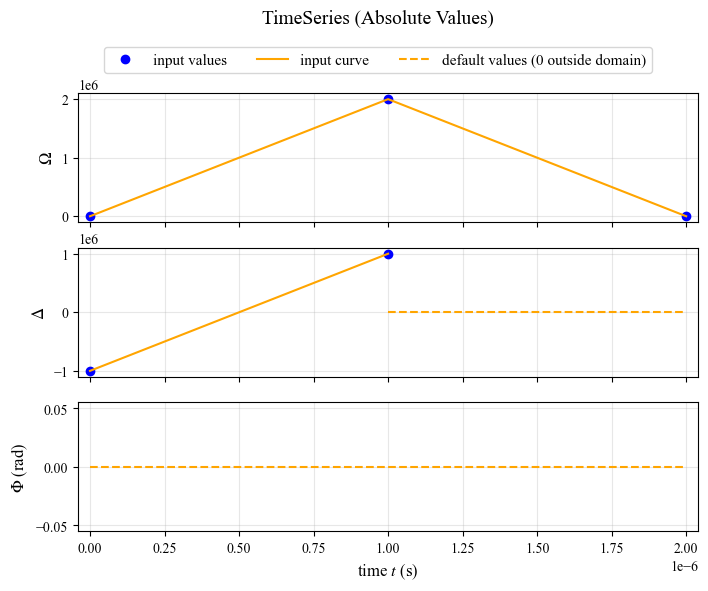

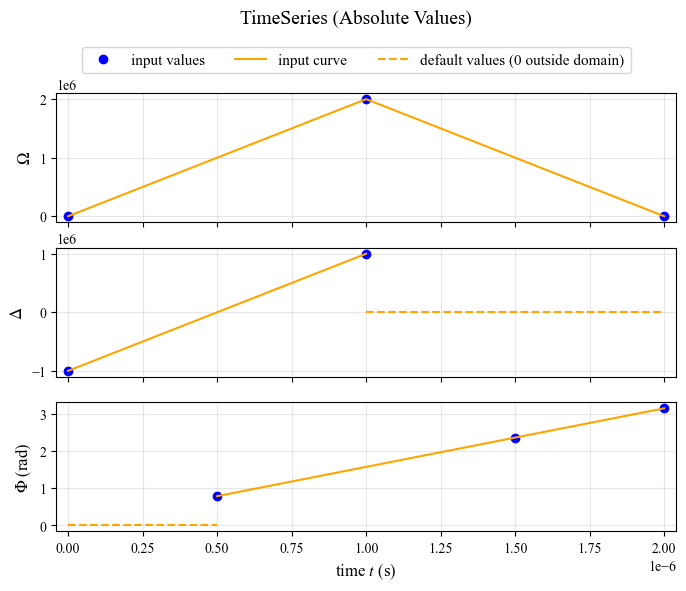

In [9]:
ts.clear()
ts.channels
# omegas
ts.add_point('Omega', 0.0, 0.0)
ts.add_point('Omega', 1e-6, 2.0e6)
ts.add_point('Omega', 2e-6, 0.0)
# deltas (leave the domain smaller than Omega)
ts.add_point('Delta', 0.0, -1.0e6)
ts.add_point('Delta', 1e-6,  1.0e6)
# phis (make it empty for now)

fig, axes = ts.plot()
plt.show()

ts.clear()
ts.channels
# omegas
ts.add_point('Omega', 0.0, 0.0)
ts.add_point('Omega', 1e-6, 2.0e6)
ts.add_point('Omega', 2e-6, 0.0)
# deltas (leave the domain smaller than Omega)
ts.add_point('Delta', 0.0, -1.0e6)
ts.add_point('Delta', 1e-6,  1.0e6)
# phis (add values but change domain)
ts.add_point('Phi', 0.5e-6, 0.25*np.pi)
ts.add_point('Phi', 1.5e-6, 0.75*np.pi)
ts.add_point('Phi', 2.0e-6, np.pi)

fig, axes = ts.plot()
plt.show()


## 9) Normalized mode  <a id='normalized'></a>

In **normalized** mode, the container enforces ranges:
- $\Omega_{\text{env}} \in [0,1]$  
- $\Delta_{\text{env}} \in [-1,1]$  
- $\Phi_{\text{env}}$ is unbounded.

This is useful when you want to apply site-dependent scaling at evolve time (e.g., $\Omega_i(t) = \Omega_{\max, i} \cdot \Omega_{\text{env}}(t)$).

TimeSeries(mode='normalized', channels=Omega[L=3, 0.000e+00→2.000e+00s], Delta[L=2, 0.000e+00→2.000e+00s])
Omega        -> [0.  0.5 1.  0.5 0. ]
Delta        -> [-1.  -0.5  0.   0.5  1. ]


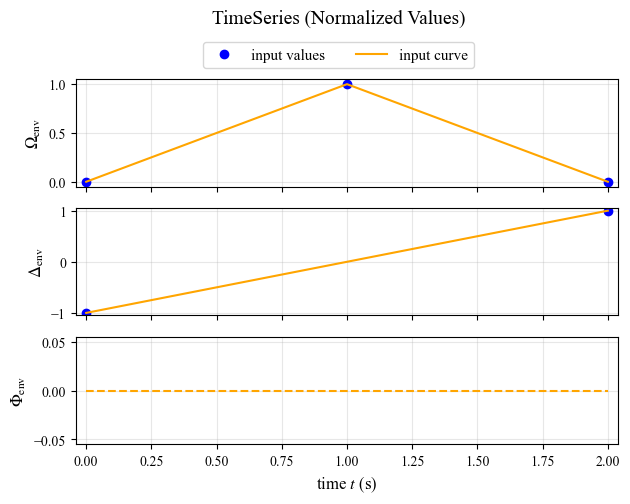

In [16]:
# Example: normalized mode
tsn = TimeSeries(mode='normalized')
tsn.add_series('Omega', [0.0, 1.0, 2.0], [0.0, 1.0, 0.0])  # triangle in [0,1]
tsn.add_series('Delta', [0.0, 2.0], [-1.0, 1.0])           # sweep in [-1,1]
print(tsn)

# Interpolate
tq = np.linspace(0.0, 2.0, 5)
vals = tsn.value_at(tq, channels=['Omega','Delta'])
for k, arr in vals.items():
    print(f"{k:12s} -> {np.array_str(arr, precision=3)}")

# Plot (y-lims reflect normalized ranges for Ω and Δ)
fig, axes = tsn.plot(figsize=(7, 5))
plt.show()

## 10) Quick status helpers <a id='status_helpers'></a>

- `is_empty` → `True` if the series holds **no channels**.
- `has_channel(name)` → `True` if a channel is present (case-sensitive).

In [17]:
ts_status = TimeSeries()
print("Empty?", ts_status.is_empty)

ts_status.add_point("Omega", 0.0, 0.1)
print("Empty after adding Omega?", ts_status.is_empty)
print("Has 'Omega'?", ts_status.has_channel("Omega"))
print("Has 'Delta'?", ts_status.has_channel("Delta"))

Empty? True
Empty after adding Omega? False
Has 'Omega'? True
Has 'Delta'? False


## 11) Shift time globally <a id='shift_time'></a>

Use `shift_time(dt)` to translate **every channel’s** time grid by a constant offset.
- Positive `dt` → shift to the right (later).
- Negative `dt` → shift to the left (earlier).

This does **not** alter values, only the timestamps. Strict ordering is preserved.

Before shift: TimeSeries(mode='absolute', channels=Omega[L=3, 0.000e+00→2.000e-06s], Delta[L=2, 0.000e+00→2.000e-06s])
Omega times: [0.e+00 1.e-06 2.e-06]
Delta times: [0.e+00 2.e-06]

After shift (+0.5 µs): TimeSeries(mode='absolute', channels=Omega[L=3, 5.000e-07→2.500e-06s], Delta[L=2, 5.000e-07→2.500e-06s])
Omega times: [5.0e-07 1.5e-06 2.5e-06]
Delta times: [5.0e-07 2.5e-06]


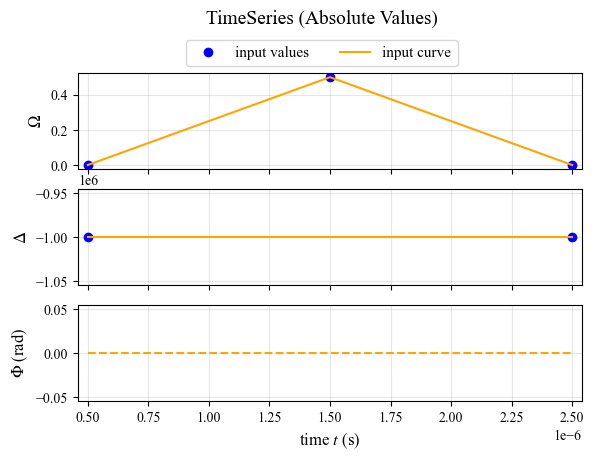

In [18]:
# Build a tiny example
ts_shift = TimeSeries(
    Omega=( [0.0e-6, 1.0e-6, 2.0e-6], [0.0, 0.5, 0.0] ),
    Delta=( [0.0e-6, 2.0e-6],        [-1.0e6, -1.0e6] ),
)

print("Before shift:", ts_shift)
print("Omega times:", ts_shift.times("Omega"))
print("Delta times:", ts_shift.times("Delta"))

# Shift by +0.5 µs
ts_shift.shift_time(0.5e-6)

print("\nAfter shift (+0.5 µs):", ts_shift)
print("Omega times:", ts_shift.times("Omega"))
print("Delta times:", ts_shift.times("Delta"))

# Optional: visualize quickly
fig, axes = ts_shift.plot(figsize=(6.5, 4.5))
plt.show()

## 12) Normalize start time to zero <a id='normalize_start'></a>

`normalize_start()` shifts **all channels** so that the earliest timestamp across
all channels becomes exactly `t = 0`. This is convenient if you’ve built schedules
piecewise and want a canonical start.

Before normalize_start: TimeSeries(mode='absolute', channels=Omega[L=2, 2.000e-07→7.000e-07s], Phi[L=2, 4.000e-07→1.000e-06s])
Union domain: (2e-07, 1e-06)

After normalize_start: TimeSeries(mode='absolute', channels=Omega[L=2, 0.000e+00→5.000e-07s], Phi[L=2, 2.000e-07→8.000e-07s])
Union domain: (0.0, 8e-07)
Omega times: [0.e+00 5.e-07]
Phi times: [2.e-07 8.e-07]


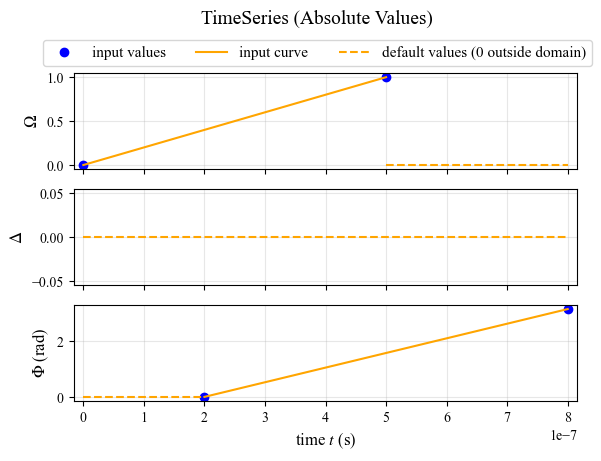

In [19]:
ts_norm = TimeSeries(
    Omega=( [0.2e-6, 0.7e-6], [0.0, 1.0] ),
    Phi  =( [0.4e-6, 1.0e-6], [0.0, 3.14] ),
)

print("Before normalize_start:", ts_norm)
print("Union domain:", ts_norm.domain())

ts_norm.normalize_start()

print("\nAfter normalize_start:", ts_norm)
print("Union domain:", ts_norm.domain())
print("Omega times:", ts_norm.times("Omega"))
print("Phi times:", ts_norm.times("Phi"))

# Optional: visualize
fig, axes = ts_norm.plot(figsize=(6.5, 4.5))
plt.show()

## 13) Mini workflow: build → check → shift → normalize <a id='mini_workflow'></a>

A quick end-to-end example that uses `has_channel`, `is_empty`, `shift_time`, and `normalize_start`.

Start empty? True
Has Omega? True
Has Phi? False
Union domain (pre-shift): (3e-07, 8e-07)
Union domain (post-shift): (1e-07, 6e-07)
Union domain (post-normalize): (0.0, 5e-07)


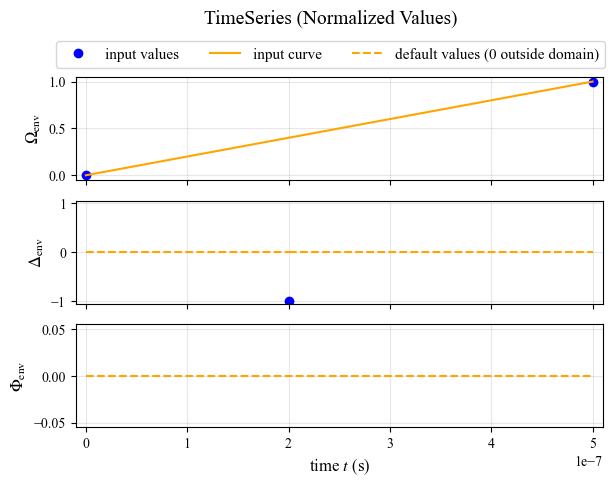

In [20]:
ts_work = TimeSeries(mode="normalized")
print("Start empty?", ts_work.is_empty)

# Add a couple of channels incrementally
ts_work.add_point("Omega", 0.3e-6, 0.0)
ts_work.add_point("Omega", 0.8e-6, 1.0)
ts_work.add_point("Delta", 0.5e-6, -1.0)

print("Has Omega?", ts_work.has_channel("Omega"))
print("Has Phi?", ts_work.has_channel("Phi"))
print("Union domain (pre-shift):", ts_work.domain())

# Shift to start earlier, then normalize back to t=0
ts_work.shift_time(-0.2e-6)
print("Union domain (post-shift):", ts_work.domain())

ts_work.normalize_start()
print("Union domain (post-normalize):", ts_work.domain())

# Visual check
fig, axes = ts_work.plot(figsize=(6.8, 4.8))
plt.show()